In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import os

from tqdm import tqdm

# Upload model
from models.R1AE import ConvLRAE, ConvVAE, ConvAE


import torchvision
from torchvision import transforms
from torch.utils.data import Subset, Dataset, DataLoader

import argparse



### argparser!
# parser = argparse.ArgumentParser(description='Run AE-type models on training')

# parser.add_argument('-m', '--model', type=str, default='LRAE',  help='model type')
# parser.add_argument('-d', '--device', type=str, default='cuda:0', help='torch device name. E.g.: cpu, cuda:0, cuda:1')
# args = parser.parse_args()



###### Setup script

## Main work parameters
# DEVICE = args.device
# MODEL_TYPE = args.model

DEVICE = 'cuda:1' 
MODEL_TYPE = 'AE'


MODEL_NAME_PREF = 'test1__'
SAVE_DIR = 'test_1_save'
# SAVE_DIR = ''


IN_FEATURES = 256*2*2
OUT_FEATURES = 128
N_BINS = 20


DROPOUT = 0.0
TEMP = 0.5
SAMPLING = 'gumbell'


TRAIN_SIZE = 60000
TEST_SIZE = 10000
BATCH_SIZE = 32

DATASET_TYPE = 'MNIST'

ALPHA = 1e-2
EPOCH_SAVE_BACKUP = 5
SHOW_LOSS_BACKUP = 5
EPOCHS = 50
LEARNING_RATE = 1e-4

NONLINEARITY = nn.ReLU()







def print_params(param_list, param_names_list):
    for param_name, param in zip(param_names_list, param_list):
        print(f"{param_name}: {param}")
    print()
    

# Show input data
print('Input script data', '\n')
print('Main parameters:')
in_param_list = [SAVE_DIR, DEVICE, MODEL_TYPE, OUT_FEATURES, DATASET_TYPE]
in_param__names_list = ['SAVE_DIR', 'DEVICE', 'MODEL_TYPE', 'OUT_FEATURES', 'DATASET_TYPE']
print_params(in_param_list, in_param__names_list)
print()

print('All model parameters:')
in_param_list = [OUT_FEATURES, NONLINEARITY, IN_FEATURES,  N_BINS, DROPOUT, TEMP, SAMPLING]
in_param__names_list = ['OUT_FEATURES', 'NONLINEARITY', 'IN_FEATURES',  'N_BINS', 'DROPOUT', 'TEMP', 'SAMPLING']
print_params(in_param_list, in_param__names_list)
print()

print('Training parameters:')
in_param_list = [BATCH_SIZE, LEARNING_RATE, ALPHA,  EPOCHS]
in_param__names_list = ['BATCH_SIZE', 'LEARNING_RATE', 'ALPHA', 'EPOCHS']
print_params(in_param_list, in_param__names_list)
print()

print('Dataset parameters:')
in_param_list = [DATASET_TYPE, TRAIN_SIZE, TEST_SIZE, BATCH_SIZE]
in_param__names_list = ['DATASET_TYPE', 'TRAIN_SIZE', 'TEST_SIZE', 'BATCH_SIZE']
print_params(in_param_list, in_param__names_list)
print()


## other parameters
NUM_WORKERS = 10

# Other parameters
print('Other parameters')
other_param_list = [NUM_WORKERS, EPOCH_SAVE_BACKUP, SHOW_LOSS_BACKUP]
other_param_names_list = ['NUM_WORKERS', 'EPOCH_SAVE_BACKUP', 'SHOW_LOSS_BACKUP']
for param_name, param in zip(other_param_names_list, other_param_list):
    print(f"{param_name}: {param}")
print()



# Service parameters
GOOD_DATASET_TYPE = ['MNIST']
GOOD_MODEL_TYPE = ['VAE', 'AE', 'LRAE']

# Checking parameters
assert MODEL_TYPE in GOOD_MODEL_TYPE, f"Error, bad model type, select from: {GOOD_MODEL_TYPE}"
assert DATASET_TYPE in GOOD_DATASET_TYPE, f"Error, bad dataset type, select from: {GOOD_DATASET_TYPE}"
#############



###################### Initialization of the model
device = DEVICE
model_name = MODEL_NAME_PREF + f"{DATASET_TYPE}__{MODEL_TYPE}__{OUT_FEATURES}__{ALPHA}"

print('\n\n')


print("Initialization of the model")
print("model_name: ", model_name, '\n\n' )
if MODEL_TYPE == 'LRAE':
    GRID = torch.arange(1,N_BINS+1).to(device)/N_BINS
    model = ConvLRAE(IN_FEATURES, OUT_FEATURES, N_BINS, GRID, dropout=DROPOUT, nonlinearity=NONLINEARITY,
                sampling=SAMPLING, temperature=TEMP,).to(device)
elif MODEL_TYPE == 'VAE':
    model = ConvVAE(IN_FEATURES, OUT_FEATURES, nonlinearity=NONLINEARITY).to(device)
elif MODEL_TYPE == 'AE':
    model = ConvAE(IN_FEATURES, OUT_FEATURES, nonlinearity=NONLINEARITY).to(device)
else:
    assert False, f"Error, bad model type, select from: {GOOD_MODEL_TYPE}"
      
print(f"{MODEL_TYPE} was initialized")
PATH = os.path.join(SAVE_DIR, model_name)
print('Save PATH:', PATH)
#################################






####### Dataset
dataset_type = DATASET_TYPE
print('\n\n')
print(f'Loading dataset: {dataset_type}')

        
# Torchvision dataset


train_ds_mnist = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 transforms.Resize(32),
                                 torchvision.transforms.ToTensor(),
                             ]))
test_ds_mnist = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 transforms.Resize(32),
                                 torchvision.transforms.ToTensor(),
                             ]))


num_workers = NUM_WORKERS


# dataset and dataloader
TRAIN_SIZE = TRAIN_SIZE
TEST_SIZE = TEST_SIZE
BATCH_SIZE = BATCH_SIZE
dl = DataLoader(train_ds_mnist, batch_size=BATCH_SIZE,     num_workers=num_workers)
dl_test = DataLoader(test_ds_mnist, batch_size=BATCH_SIZE, num_workers=num_workers)

#full dataset train
FULL_TRAIN_SIZE = TRAIN_SIZE
dl_full = DataLoader(train_ds_mnist, batch_size=FULL_TRAIN_SIZE)
for x, y in dl_full:
    X_full_train = x
    targets = y
    break

#full dataset train
FULL_TEST_SIZE = TEST_SIZE
dl_full = DataLoader(test_ds_mnist, batch_size=FULL_TEST_SIZE)
for x, y in dl_full:
    X_full_test = x
    targets_test = y
    break

print("Dataset parameters:")
for param, param_name in zip([TRAIN_SIZE, TEST_SIZE, BATCH_SIZE], ["TRAIN_SIZE", "TEST_SIZE", "BATCH_SIZE"] ):
    print(f"{param_name} = {param}")

print("dataset logs:")
print(X_full_train.shape)
print(torch.max(X_full_train))
print(targets.unique(return_counts=True))

print('\n\n')
###################





/home/s.gostilovich/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Input script data 

Main parameters:
SAVE_DIR: test_1_save
DEVICE: cuda:1
MODEL_TYPE: AE
OUT_FEATURES: 128
DATASET_TYPE: MNIST


All model parameters:
OUT_FEATURES: 128
NONLINEARITY: ReLU()
IN_FEATURES: 1024
N_BINS: 20
DROPOUT: 0.0
TEMP: 0.5
SAMPLING: gumbell


Training parameters:
BATCH_SIZE: 32
LEARNING_RATE: 0.0001
ALPHA: 0.01
EPOCHS: 50


Dataset parameters:
DATASET_TYPE: MNIST
TRAIN_SIZE: 60000
TEST_SIZE: 10000
BATCH_SIZE: 32


Other parameters
NUM_WORKERS: 10
EPOCH_SAVE_BACKUP: 1
SHOW_LOSS_BACKUP: 1




Initialization of the model
model_name:  test1__MNIST__AE__128__0.01 


AE was initialized
Save PATH: test_1_save/test1__MNIST__AE__128__0.01



Loading dataset: MNIST
Dataset parameters:
TRAIN_SIZE = 60000
TEST_SIZE = 10000
BATCH_SIZE = 32
dataset logs:
torch.Size([60000, 1, 32, 32])
tensor(1.)
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))





Training of the model


  6%|▌         | 3/50 [02:31<39:39, 50.62s/it]


KeyboardInterrupt: 

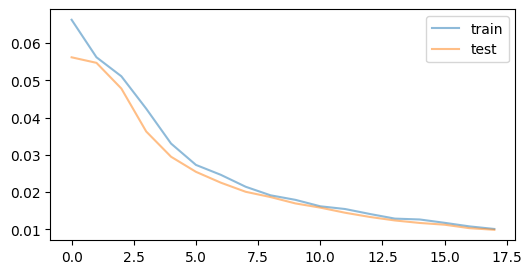

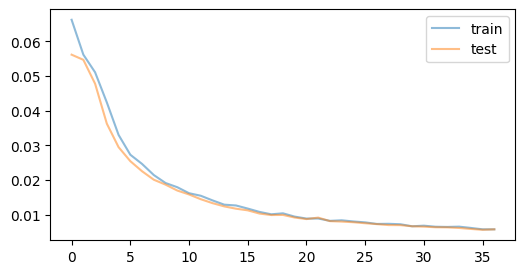

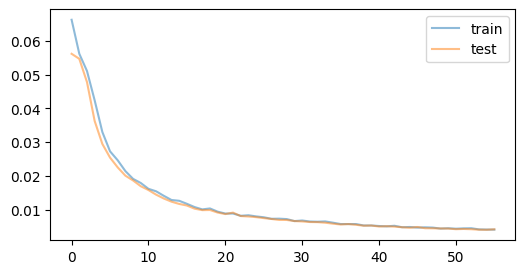

In [2]:


######## Training
print("Training of the model")


# setup training
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


PATH = PATH
EPOCHS = EPOCHS


loss_list_train = []
loss_train_cum = 0

loss_list_test = []
loss_test_cum = 0
i = 0
loss = 0


alpha_kl = ALPHA
alpha_entropy = ALPHA
epoch_save_backup = EPOCH_SAVE_BACKUP
show_loss_backup = SHOW_LOSS_BACKUP


# Training
model.train()
optimizer.zero_grad()
torch.cuda.empty_cache()

for epoch in tqdm(range(EPOCHS)):
    # Forward pass: Compute predicted y by passing x to the model
        
    # Training
    model.train() # Model to train
    for x_batch, y_batch in dl:

        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # model forward
        # 2d downsampling
        x_down = model.down(x_batch)
        B, C, H, W = x_down.shape
        x_flat = x_down.view(B,C*H*W)
        
        encoded_out_dim, factors_probability = model.low_rank.low_rank_pants(x_flat)
        decoded_1d = model.low_rank.decoder(encoded_out_dim)
        
        # 2d upsampling
        decoded_2d_small = decoded_1d.view(B, C, H, W)
        decoded_2d = model.up(decoded_2d_small)
        
        # loss

#         loss_entropy = torch.sum(torch.log(factors_probability+1e-9)*factors_probability,dim=-1)
        # factors_probability = nn.Softmax(dim=-1)(factors_probability)
        # loss_entropy = torch.sum(torch.log(factors_probability+1e-9)*factors_probability,dim=-1)
        loss = criterion(decoded_2d.view(-1), x_batch.view(-1)) 
        if MODEL_TYPE == 'VAE':
            loss += alpha_kl*factors_probability.mean()  # KL loss
            
        if MODEL_TYPE == 'LRAE':
            factors_probability = nn.Softmax(dim=-1)(factors_probability)
            loss_entropy = torch.sum(torch.log(factors_probability+1e-9)*factors_probability,dim=-1)            
            loss += alpha_entropy*torch.mean(torch.exp(loss_entropy)) # entropy loss
            
            
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # accumulate loss
        loss_train_cum += loss.item()
        
        # validation and saving
        i += 1
        if i % 100 == 0:
            loss_list_train.append(loss_train_cum/100)
            loss_train_cum = 0
            with torch.no_grad():
                model.eval() # put to eval
                for x_batch, y_batch in dl_test:
                    # model forward
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    x_decoded = model(x_batch)

                    loss_test = criterion(x_decoded.view(-1), x_batch.view(-1))
                    loss_test_cum += loss_test.item()
                    
            assert torch.isnan(x_decoded).sum() == 0, f"Error! Nan values ({torch.isnan(x_decoded).sum()}) in models output"
      
            # save to list
            loss_list_test.append(loss_test_cum/len(dl_test))
            loss_test_cum = 0
          
            
    # backup saving  
    if epoch%epoch_save_backup == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'loss_list_train': loss_list_train,
            'loss_list_test': loss_list_test,
            
            }, PATH + f"__{epoch}.pth")
      
    # loss printing        
    if (epoch % show_loss_backup == show_loss_backup-1) or (epoch == EPOCHS -1):
        fig = plt.figure(figsize=(6,3))
        plt.plot(loss_list_train, alpha=0.5, label='train')
        plt.plot(loss_list_test, alpha=0.5, label='test')
        plt.legend()
        plt.savefig( PATH  + "_loss.png")
        pass
            
            
        



print("Finishing of the training...")
torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'loss_list_train': loss_list_train,
        'loss_list_test': loss_list_test,
        
        }, PATH + f"__{epoch}__end.pth")

print("Model training was successfully finished and saved!")





#######################
